### Wavelet Transform

In [ ]:
import zipfile

zip_file_path = '/content/tfa_data.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/tfa_data')

import os
os.listdir('/content/tfa_data')

['tfa_data']

In [6]:
alcoholic_data_path = '/content/tfa_data/tfa_data/alcoholic/'
control_data_path = '/content/tfa_data/tfa_data/control/'

In [9]:
pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 54.6 MB/s eta 0:00:00


In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import pywt
from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

In [11]:
def load_data_from_folder(folder_path, label):
    data = []
    labels = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            try:
                df = pd.read_csv(file_path, on_bad_lines='skip')
            except pd.errors.ParserError as e:
                print(f"ParserError in file: {filename}")
                continue


            df.columns = df.columns.str.strip()

            # 'sensor value' - EEG signal
            if 'sensor value' in df.columns:
                eeg_signal = df['sensor value'].values

                # 'sensor value' column to extract features
                data.append(eeg_signal)
                labels.append(label)  # 1 for alcoholic, 0 for control
            else:
                print(f"Warning: 'sensor value' column not found in {filename}")

    return data, labels

In [12]:
alcoholic_data, alcoholic_labels = load_data_from_folder(alcoholic_data_path, label=1)
control_data, control_labels = load_data_from_folder(control_data_path, label=0)
X = np.concatenate((alcoholic_data, control_data), axis=0)
y = np.concatenate((alcoholic_labels, control_labels), axis=0)

In [13]:
# Feature extraction function using Wavelet Transform
def extract_wavelet_features(eeg_signal):
    coeffs = pywt.wavedec(eeg_signal, 'db4', level=5)  #5 levels
    features = []

    for i, coeff in enumerate(coeffs):
        features.append(np.mean(coeff))
        features.append(np.std(coeff))
        features.append(np.sum(np.square(coeff)))
        features.append(entropy(np.abs(coeff)))

        total_energy = np.sum(np.square(coeffs[i]))
        relative_energy = np.sum(np.square(coeff)) / total_energy if total_energy != 0 else 0
        features.append(relative_energy)

    return features


In [14]:
features = []
for eeg_signal in X:
    features.append(extract_wavelet_features(eeg_signal))

# into dataFrame for easier handling
wavelet_features_df = pd.DataFrame(features)


In [15]:
# Normalize-using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(wavelet_features_df)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [16]:
#SVM model with RBF kernel
svm_model = SVC(kernel='rbf', C=1, gamma='scale')

# Train
svm_model.fit(X_train, y_train)

# Test
y_pred = svm_model.predict(X_test)

Accuracy: 83.33%
F1 Score: 0.83
ROC-AUC: 0.84


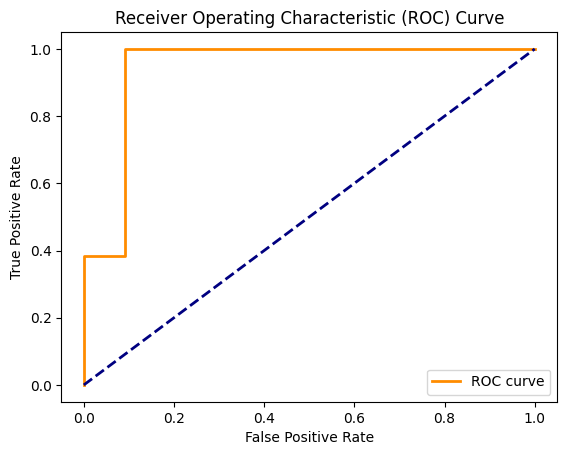

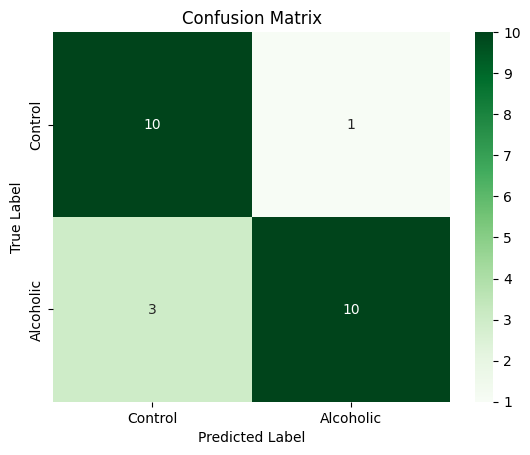

In [18]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

#evaluation metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

#ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, svm_model.decision_function(X_test))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#heatmap
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Control', 'Alcoholic'],
            yticklabels=['Control', 'Alcoholic'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### Hilbert Hunag Transform

In [1]:
pip install pyEMD scipy matplotlib pandas numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 666.6/666.6 kB 15.3 MB/s eta 0:00:00


In [2]:
!pip install emd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.3/147.3 kB 12.4 MB/s eta 0:00:00


In [3]:
%pip install EMD-signal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.3 MB/s eta 0:00:00


In [20]:
import numpy as np
import pandas as pd
from scipy.signal import hilbert
from PyEMD import EMD
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
def extract_features_with_pyemd(signal):
    # Empirical Mode Decomposition (EMD)
    emd = EMD()
    imfs = emd(signal)  #IMFs

    hht_features = []

    for imf in imfs:
        #Hilbert Transform on each IMF
        analytic_signal = hilbert(imf)
        amplitude_envelope = np.abs(analytic_signal)
        instantaneous_phase = np.unwrap(np.angle(analytic_signal))
        instantaneous_frequency = np.diff(instantaneous_phase)

        features = {
            'mean_amp': np.mean(amplitude_envelope),
            'std_amp': np.std(amplitude_envelope),
            'mean_freq': np.mean(instantaneous_frequency),
            'std_freq': np.std(instantaneous_frequency),
        }
        hht_features.append(features)

    features = {
        'mean_amp': np.mean([f['mean_amp'] for f in hht_features]),
        'std_amp': np.mean([f['std_amp'] for f in hht_features]),
        'mean_freq': np.mean([f['mean_freq'] for f in hht_features]),
        'std_freq': np.mean([f['std_freq'] for f in hht_features]),
    }

    return features


In [22]:
X_features_hht = np.array([list(extract_features_with_pyemd(signal).values()) for signal in X])

X_train_hht, X_test_hht, y_train_hht, y_test_hht = train_test_split(X_features_hht, y, test_size=0.3, random_state=42)

In [25]:
svm_model = SVC(kernel='rbf', C=1, gamma='scale')
svm_model.fit(X_train_hht, y_train_hht)

#test
y_pred_hht = svm_model.predict(X_test_hht)

Accuracy: 61.11%
F1 Score: 0.42
ROC-AUC: 0.63


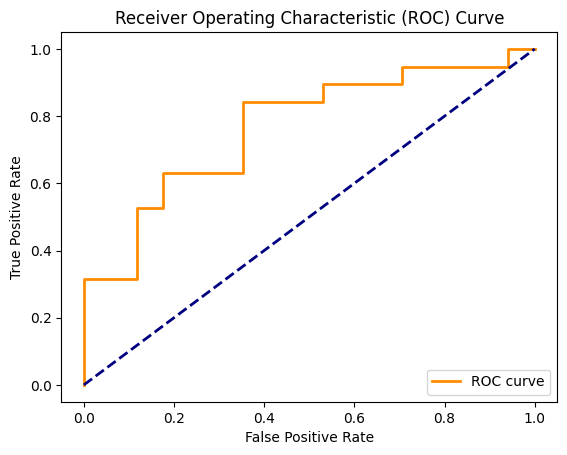

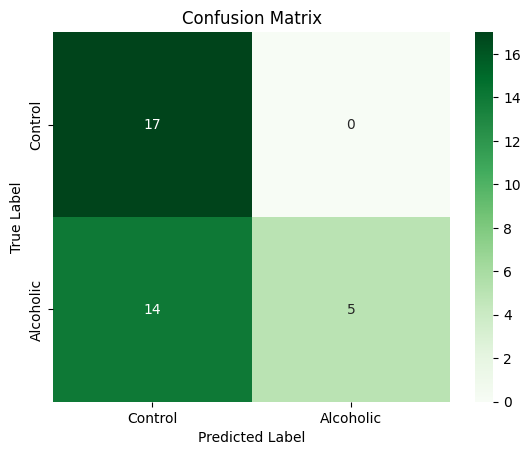

In [27]:
accuracy = accuracy_score(y_test_hht, y_pred_hht)
f1 = f1_score(y_test_hht, y_pred_hht)
roc_auc = roc_auc_score(y_test_hht, y_pred_hht)

#evaluation metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

#ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test_hht, svm_model.decision_function(X_test_hht))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#heatmap
cm = confusion_matrix(y_test_hht, y_pred_hht)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Control', 'Alcoholic'],
            yticklabels=['Control', 'Alcoholic'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
